<a href="https://colab.research.google.com/github/ducquanhp28112002/Machine_Learning/blob/main/OnlineRetail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Khai báo thư viện**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [ ]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### **Đọc dữ liệu**

In [ ]:
df = pd.read_csv("OnlineRetail.csv", delimiter = ",", encoding = "ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


### **Tìm hiểu về dữ liệu**

In [ ]:
# Kích thước
df.shape

(541909, 8)

In [ ]:
# Thông tin
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### **Làm sạch dữ liệu**

In [ ]:
df_null = round(100 * (df.isnull().sum()) / len(df), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [ ]:
# Xóa dòng có dữ liệu bị thiếu
df = df.dropna()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
# Chuyển đổi định dạng của cột "CustomerID"
df["CustomerID"] = df["CustomerID"].astype(str)

### **Phân tích RFM**

- R (Recency): Số ngày kể từ lần mua gần đây nhất.
- F (Frequency): Số lần mua (Tần suất).
- M (Monetary): Doanh thu

In [ ]:
df["Amount"] = df["Quantity"] * df["UnitPrice"]
rfm_m = df.groupby("CustomerID")["Amount"].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [ ]:
rfm_f = df.groupby("CustomerID")["InvoiceNo"].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ["CustomerID", "Frequency"]
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [ ]:
# Hợp nhất hai DataFrame trên
rfm = pd.merge(rfm_m, rfm_f, on = "CustomerID", how = "inner")
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [ ]:
# Chuyển đổi định dạng của cột "InvoiceDate"
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format = "%d-%m-%Y %H:%M")

In [ ]:
# Xem ngày bán cuối cùng trong dữ liệu trên
last_date = max(df["InvoiceDate"])
last_date

Timestamp('2011-12-09 12:50:00')

In [ ]:
# Thêm cột chỉ khoảng cách giữa ngày mua với last_date
df["Dis"] = last_date - df["InvoiceDate"]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Dis
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [ ]:
rfm_p = df.groupby("CustomerID")["Dis"].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Dis
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [ ]:
rfm_p = df.groupby("CustomerID")["Dis"].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Dis
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [ ]:
# Cột "Dis" chỉ lấy ngày
rfm_p["Dis"] = rfm_p["Dis"].dt.days
rfm_p.head()

,CustomerID,Dis
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [ ]:
# Gộp ba DataFrame lại với nhau
rfm = pd.merge(rfm, rfm_p, on = "CustomerID", how = "inner")
rfm.columns = ["CustomerID", "Amount", "Frequency", "Recency"]
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


### **Xử lý dữ liệu ngoại lai**

Text(0, 0.5, 'Range')

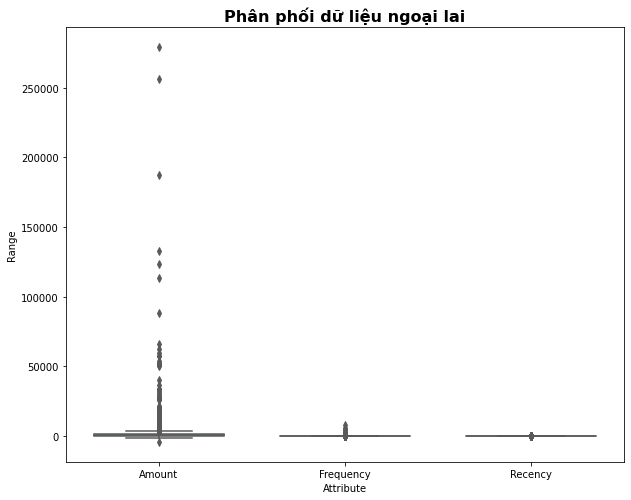

In [ ]:
attribute = ["Amount", "Frequency", "Recency"]
plt.rcParams["figure.figsize"] = [10, 8]
sns.boxplot(data = rfm[attribute], orient = "v", palette = "Set2", whis = 1.5, saturation = 1, width = 0.7)
plt.title("Phân phối dữ liệu ngoại lai", fontsize = 16, fontweight = "bold")
plt.xlabel("Attribute")
plt.ylabel("Range")

In [ ]:
# Loại bỏ dữ liệu ngoại lai
Q1 = rfm["Amount"].quantile(0.05)
Q3 = rfm["Amount"].quantile(0.95)
IOR = Q3 - Q1
rfm = rfm[(rfm["Amount"] >= Q1 - 1.5 * IOR) & (rfm["Amount"] <= Q3 + 1.5 * IOR)]

In [ ]:
# Loại bỏ dữ liệu ngoại lai
Q1 = rfm["Frequency"].quantile(0.05)
Q3 = rfm["Frequency"].quantile(0.95)
IOR = Q3 - Q1
rfm = rfm[(rfm["Frequency"] >= Q1 - 1.5 * IOR) & (rfm["Frequency"] <= Q3 + 1.5 * IOR)]

In [ ]:
# Loại bỏ dữ liệu ngoại lai
Q1 = rfm["Recency"].quantile(0.05)
Q3 = rfm["Recency"].quantile(0.95)
IOR = Q3 - Q1
rfm = rfm[(rfm["Recency"] >= Q1 - 1.5 * IOR) & (rfm["Recency"] <= Q3 + 1.5 * IOR)]

In [ ]:
rfm_df = rfm[attribute]

scaler = StandardScaler()

rfm_df_scale = scaler.fit_transform(rfm_df)
rfm_df_scale.shape

(4293, 3)

### **K - Means Clustering**

##### *Phương pháp Elbow*

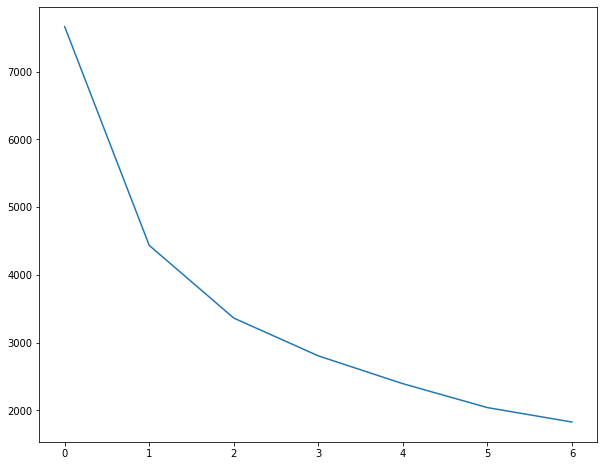

In [ ]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = num_clusters, max_iter = 50)
    kmeans.fit(rfm_df_scale)
    
    ssd.append(kmeans.inertia_)
    
plt.plot(ssd)

##### *Sihouette Analysis*

silhoutte score = $\frac{p - q}{max(p, q)}$

$p$ là khoảng cách trung bình đến các điểm trong cụm gần nhất mà điểm dữ liệu không phải là một phần của cụm đó.
$q$ là khoảng cách trung bình từ điểm dữ liệu trong cụm đến tất cả các điểm trong cụm của chính nó.

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = num_clusters, max_iter = 50)
    kmeans.fit(rfm_df_scale)
    
    cluster_labels = kmeans.labels_
    
    # Điểm Silhoutte
    silhouette_avg = silhouette_score(rfm_df_scale, cluster_labels)
    print("Với n_clusters = {0}, điểm Silhoutte là {1}".format(num_clusters, silhouette_avg))

Với n_clusters = 2, điểm Silhoutte là 0.5415858652525395
Với n_clusters = 3, điểm Silhoutte là 0.5084896296141937
Với n_clusters = 4, điểm Silhoutte là 0.4781841150952288
Với n_clusters = 5, điểm Silhoutte là 0.46481058150500315
Với n_clusters = 6, điểm Silhoutte là 0.4169515238218781
Với n_clusters = 7, điểm Silhoutte là 0.4180674850945673
Với n_clusters = 8, điểm Silhoutte là 0.4024666032705298


In [ ]:
# Mô hình cuối cùng với k = 3
kmeans = KMeans(n_clusters = 3, max_iter = 50)
kmeans.fit(rfm_df_scale)

KMeans(max_iter=50, n_clusters=3)

In [ ]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0], dtype=int32)

In [ ]:
# Gán nhãn
rfm["Cluster_Id"] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


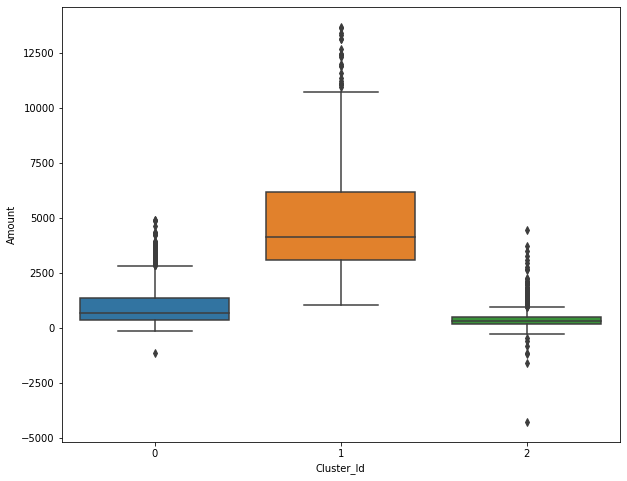

In [ ]:
# Vẽ biểu đồ boxplot cho thuộc tính "Cluster_Id" và "Amount"
sns.boxplot(x = "Cluster_Id", y = "Amount", data = rfm)

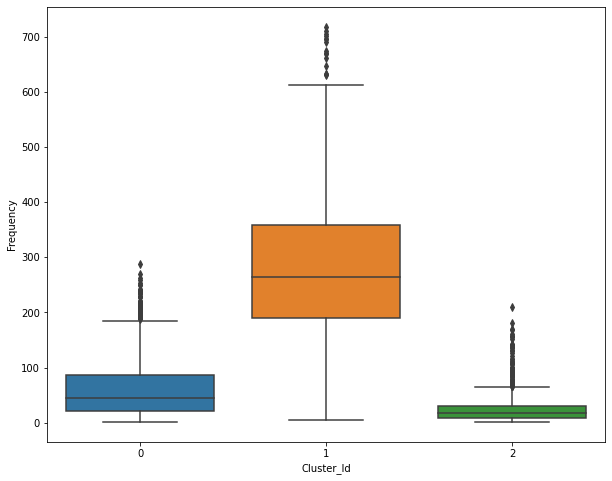

In [ ]:
# Vẽ biểu đồ boxplot cho thuộc tính "Cluster_Id" và "Frequency"
sns.boxplot(x = "Cluster_Id", y = "Frequency", data = rfm)

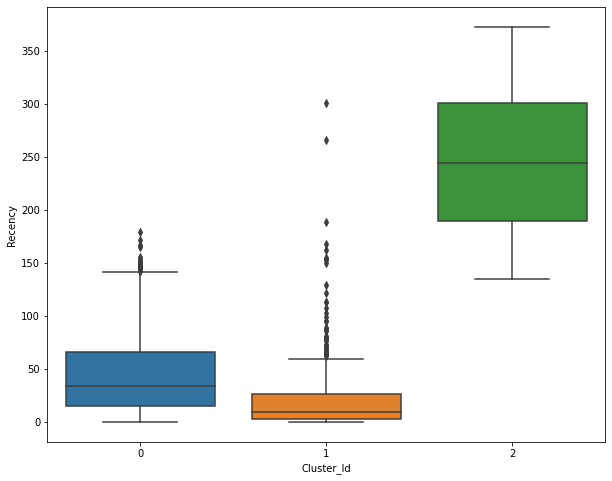

In [ ]:
# Vẽ biểu đồ boxplot cho thuộc tính "Cluster_Id" và "Recency"
sns.boxplot(x = "Cluster_Id", y = "Recency", data = rfm)

##### *Nhận xét*

- Khách hàng có Cluster_Id cụm 3 có lượng mua cao hơn so với các khách hàng khác.
- Khách hàng có Cluster_Id cụm 3 là những người mua thường xuyên nhất.
- Khách hàng có Cluster_Id cụm 2 không phải là những người mua gần đây nhiều. Từ đó dẫn đến đây là những đối tượng ít quan trọng trong chiến lược bán hàng.